In [1]:
# vim: set filetype=python:

# Bayesian Regression

Bayesian Regression with evidence approximation introduces normal prior on parameters (except for bias term) and therefore does not allow parameters have exterme estimates. It is similar to ridge regression, however does not need cross-validation.

## scikit-learn API

In [1]:
from sklearn.utils.estimator_checks import check_estimator
from bayesian_regression import BayesianRegression
check_estimator(BayesianRegression)

## Example 1 , variance of coefficients and overfitting

Variance of coefficients in OLS is extremely high in case of multicollinearity and presence of noisy features.
Bayesian Regression solves that problem by penalising large values of coefficients. 
Example below shows that coefficient values produced by Bayesian Regression are not as volatile as estimates generated by OLS. It also shows that OLS has better mse on training set (which comes as no surprise since OLS loss function is MSE), but significantly worse results on test set, indicating that OLS overfits data.

Training set 

MSE for Bayesian Regression 0.637722326061 on training set
MSE for OLS 7.445411646e-30 on training set 

Test set 

MSE for Bayesian Regression 1.15175290672 on test set
MSE for OLS 1.4787506915 on test set


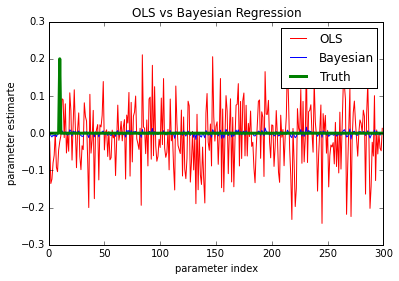

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
from bayesian_regression import BayesianRegression
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
%matplotlib inline

# generate features that will be highly correlated
np.random.seed(0)
n, m              = 100, 300
X                 = np.random.random([n,m])

# Define only one feature to be relevant
Theta             = np.zeros(m)
Theta[10]         = .2

# Ganerate linear model with noise
Y                 = np.dot(X, Theta) + np.random.normal(0,1,100)

# train & test split
X,x,Y,y           = train_test_split(X,Y, test_size = 0.4)

# Fit the Bayesian Regression and an OLS for comparison
br                = BayesianRegression()
br.fit(X,Y)

ols               = LinearRegression()
ols.fit(X, Y)

# mse on training data
Mu        = br.predict(X) # mean of predictive distribution
Y_hat     = ols.predict(X)

# train mse
mse_ols_train   = np.mean((Y_hat - Y)**2)
mse_bayes_train = np.mean((Mu    - Y)**2)

# mse on test data
mu        = br.predict(x) # mean of predictive distribution
y_hat     = ols.predict(x)

# test mse
mse_ols_test   = np.mean((y_hat - y)**2)
mse_bayes_test = np.mean((mu    - y)**2)

print "Training set \n"
print "MSE for Bayesian Regression {0} on training set".format(mse_bayes_train)
print "MSE for OLS {0} on training set \n".format(mse_ols_train)

print "Test set \n"
print "MSE for Bayesian Regression {0} on test set".format(mse_bayes_test)
print "MSE for OLS {0} on test set".format(mse_ols_test)

plt.plot(ols.coef_,"r-",label = "OLS")
plt.plot(br.coef_  ,"b-",label = "Bayesian")
plt.plot(Theta,"g-", label = "Truth", linewidth = 3)
plt.xlabel("parameter index")
plt.ylabel("parameter estimarte")
plt.title("OLS vs Bayesian Regression")
plt.legend(loc = 1)
plt.show()



As you can see parameter estimates of Bayesian Regression are not as volatile as estimates produced by OLS. 

## Example 2,  predictive distribution

Bayesian Regression can provide not only point prediction but also distribution of target values for each data point 
in test set.

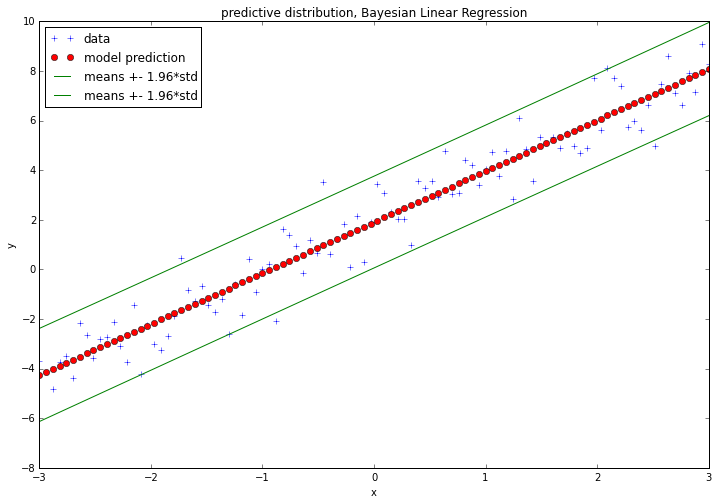

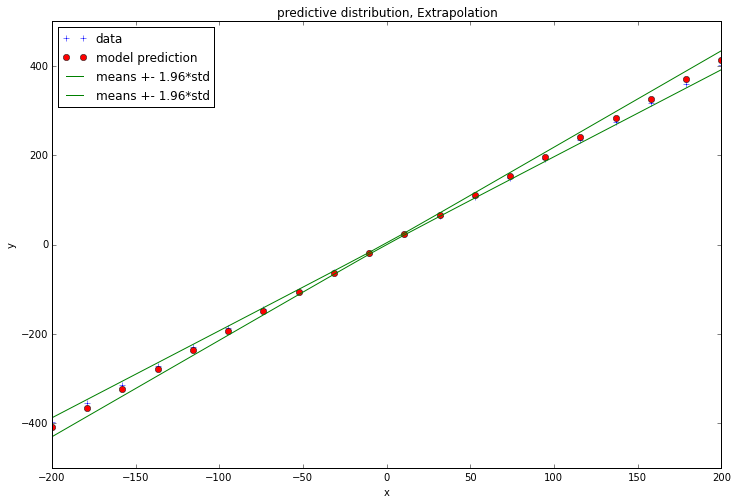

In [3]:
x           = np.zeros([100,1])
x[0:100,0]  = np.linspace(-3,3,100)
model       = lambda x: 2 + 2*x[:,0]
y           = model(x) + np.random.normal(0,1,100)
br2         = BayesianRegression()
br2.fit(x,y)
x_test      = np.zeros([20,1])
x_test[:,0] = np.linspace(-200,200,20)
y_hat, var  = br2.predict_dist(x_test)
y_model     = model(x_test)


def simple_plotter(x,y, br = None, title = None):
    '''
    Plots mean and variance of predictive distribution
    '''
    # predictive distribution
    y_hat, var = br.predict_dist(x)
    y_lo       = y_hat - 1.96*np.sqrt(var)
    y_hi       = y_hat + 1.96*np.sqrt(var)
    # plotting
    plt.figure(figsize = (12,8))
    plt.plot(x[:,0],y,"b+",label = 'data')
    plt.plot(x[:,0],y_hat,'ro', label = 'model prediction')
    plt.plot(x[:,0],y_lo,'g-', label = 'means +- 1.96*std')
    plt.plot(x[:,0],y_hi,'g-', label = 'means +- 1.96*std')    
    plt.legend(loc = 2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.show()
    return y_hat, var
    
    
y1,v1 = simple_plotter(x,y,br2,'predictive distribution, Bayesian Linear Regression')
y2,v2 = simple_plotter(x_test,y_model,br2,'predictive distribution, Extrapolation')

Note that for test data that are far from training data error bounds (variance of predictive distribution) become
larger.

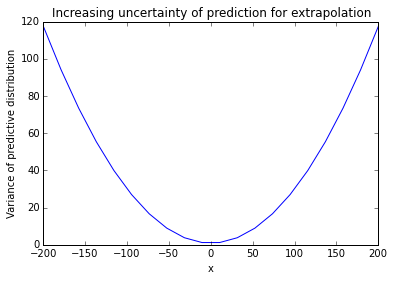

In [4]:
plt.plot(x_test[:,0],var)
plt.xlabel('x')
plt.ylabel('Variance of predictive distribution')
plt.title('Increasing uncertainty of prediction for extrapolation')
plt.show()

## Example 3: Perfect multicollinearity and zero noise variance

In [5]:
X  = np.array([ [ 0.1,  -0.1,  -0.2,   0.02],
                [ 0.3,  -0.3,  -0.6,   0.06],
                [ 0.4,  -0.4,  -0.8,   0.08],
                [ 0.5,  -0.5,  -1.,    0.1 ]])

Y  = np.array([ 0.2,  0.6,  0.8,  1.])

    
# fixed-point iteration method
br_fp = BayesianRegression(optimizer = 'fp')
br_fp.fit(X,Y)
y_fp, var_fp  = br_fp.predict_dist(X)

# Expectation Maximization
br_em = BayesianRegression(optimizer = 'em')
br_em.fit(X,Y)
y_em, var_em = br_em.predict_dist(X)

bayesian_regression.py:137: UserWarning: Almost perfect fit!!! Estimated values of variance for predictive distribution are computed using only Residual Sum of Squares, terefore they do not increase in case of extrapolation
  warnings.warn( ('Almost perfect fit!!! Estimated values of variance '


Both fixed-point and EM have near perfect fit and small variance.

In [6]:
print y_fp - Y
print y_em - Y

[  6.97323609e-05   7.74804010e-06  -2.32441203e-05  -5.42362807e-05]
[ 0.00306796  0.00034088 -0.00102265 -0.00238619]


In [7]:
print var_fp
print var_em

[  8.37913135e-05   5.34625940e-05   5.64954659e-05   7.16598257e-05]
[ 0.03356409  0.0214668   0.02267653  0.02872518]


In [8]:
print np.linalg.slogdet(br_fp.sigma_)

(1.0, -18.603361011132165)


As you can see covariance matrix is positive definite even in case of perfect multicollinearity and zero noise.
(Thanks to Sergey Feldman for example & finding important error in code)